In [1]:
print('hêlo')

hêlo


In [2]:
import requests
import json
import textwrap

In [3]:
OLLAMA_URL = "http://localhost:11434/api/generate"
payload = {
    "model": "mistral",
    "prompt": "Hãy giải thích AI là gì một cách đơn giản.",
    "stream": True
}

In [19]:
line_width = 10100  
current_line_length = 0

In [18]:
# Gửi request stream
response = requests.post(OLLAMA_URL, json=payload, stream=True)

# Xử lý từng chunk JSON
for line in response.iter_lines():
    if line:
        data = json.loads(line.decode('utf-8'))
        chunk = data.get("response", "")
        
        for char in chunk:
            print(char, end="", flush=True)
            current_line_length += 1
            if current_line_length >= line_width:
                print()  # xuống dòng
                current_line_length = 0


 AI (Artificial Intelligence) là một loại công nghệ máy tính dành cho việc sử dụ
ng các phương pháp tự động hóa và quyết định tốt để giải quyết nhiều loại công v
iệc thay vì người láng giềng hoặc có khả năng mang tính con người trong việc giả
i quyết các vấn đề. AI cho phép máy tính có thể học, nhận thức và gợi ý, giúp ti
ện lợi và tăng hiệu quả trong một số lĩnh vực như máy tính xác thực, robotics, x
ử lý ngôn ngữ, vận động cơ điện tử và truyền thông.

In [17]:
from langchain_community.llms import Ollama
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import json

In [18]:
llm = Ollama(base_url="http://localhost:11434", model="mistral")

In [ ]:
#cần prompt thật kĩ, ví dụ output đầy đủđủ

In [19]:
template = """
Hãy trích xuất các thực thể (entities) và quan hệ (relations) từ đoạn văn sau để xây đồ thị tri thức. Trả về kết quả JSON dạng:

{{
  "nodes": [{{"id": "<Entity>", "type": "<Type>"}}],
  "edges": [{{"source": "<Entity1>", "target": "<Entity2>", "relation": "<Relation>"}}]
}}

Đoạn văn:
{paragraph}
"""

prompt = PromptTemplate(input_variables=["paragraph"], template=template)

chain = LLMChain(llm=llm, prompt=prompt)

paragraph = """Trí tuệ nhân tạo (AI) là một lĩnh vực của khoa học máy tính nghiên cứu về việc tạo ra các hệ thống có khả năng thực hiện những nhiệm vụ mà trước đây chỉ con người mới làm được. Các ứng dụng của AI rất đa dạng, từ xe tự lái, nhận diện khuôn mặt, đến trợ lý ảo như Siri và ChatGPT. AI bao gồm nhiều lĩnh vực con, như học máy (machine learning), học sâu (deep learning), và xử lý ngôn ngữ tự nhiên (NLP)."""

kg_json = chain.invoke({"paragraph": paragraph})


In [20]:
kg = json.loads(kg_json["text"])
print(json.dumps(kg, indent=2, ensure_ascii=False))


{
  "nodes": [
    {
      "id": "AI",
      "type": "Lĩnh vực"
    },
    {
      "id": "Xe tự lái",
      "type": "Ứng dụng"
    },
    {
      "id": "Nhận diện khuôn mặt",
      "type": "Ứng dụng"
    },
    {
      "id": "Siri",
      "type": "Trợ lý ảo"
    },
    {
      "id": "ChatGPT",
      "type": "Trợ lý ảo"
    },
    {
      "id": "Học máy",
      "type": "Lĩnh vực con của AI"
    },
    {
      "id": "Học sâu",
      "type": "Lĩnh vực con của AI"
    },
    {
      "id": "Xử lý ngôn ngữ tự nhiên",
      "type": "Lĩnh vực con của AI"
    }
  ],
  "edges": [
    {
      "source": "AI",
      "target": "Xe tự lái",
      "relation": "Lĩnh vực con"
    },
    {
      "source": "AI",
      "target": "Nhận diện khuôn mặt",
      "relation": "Lĩnh vực con"
    },
    {
      "source": "AI",
      "target": "Siri",
      "relation": "Lĩnh vực con"
    },
    {
      "source": "AI",
      "target": "ChatGPT",
      "relation": "Lĩnh vực con"
    },
    {
      "source": "AI",
    

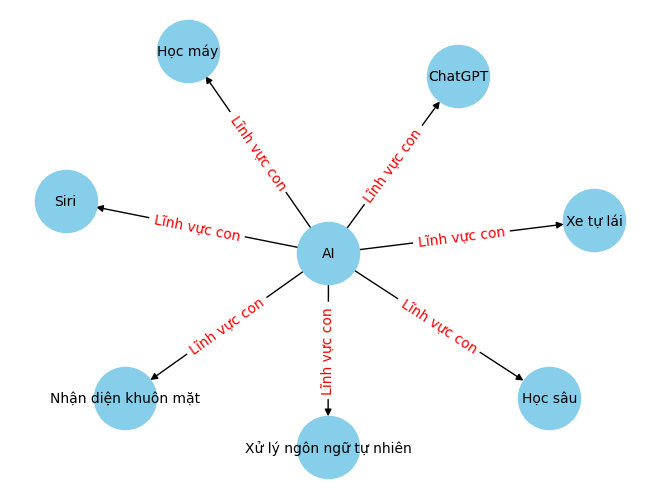

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add nodes
for node in kg["nodes"]:
    G.add_node(node["id"], type=node["type"])

# Add edges
for edge in kg["edges"]:
    G.add_edge(edge["source"], edge["target"], label=edge["relation"])

# Draw graph
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=2000, font_size=10)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
plt.show()


In [23]:
with open("knowledge_graph.json", "w", encoding="utf-8") as f:
    json.dump(kg, f, ensure_ascii=False, indent=2)